# Modelo de deep learning baseado na memória de curto prazo (LSTM)

## Bibliotecas

In [11]:

# Estamos usando a versão 3.10.11 do python

# pip install pandas tensorflow matplotlib scikit-learn pandas_datareader

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import os
pd.options.mode.chained_assignment = None

## Tratmento das bases

In [12]:
# Diretório onde o script está localizado
base_diretório = Path(os.getcwd())
base_diretório = base_diretório.parent
caminho = base_diretório / 'Bases' / 'BNB Historical Data.csv'

# Ler arquivo da base
acao = pd.read_csv(caminho)

# Formatar data
acao['Date'] = pd.to_datetime(acao['Date'], format='%m/%d/%Y')

# Filtrar a data em que vamos puxar os dados
# acao = acao[acao['Date'].dt.year >= 2023]

# Converter as colunas referentes a dinheiro para float
colunas_dinheiro = ['Price', 'Open', 'High', 'Low']
for coluna in colunas_dinheiro:
    if acao[coluna].dtype == 'object':  
        acao[coluna] = pd.to_numeric(acao[coluna].str.replace(',', ''))

# Converter a coluna 'Change %' para float
if acao['Change %'].dtype == 'object':  
    acao['Change %'] = pd.to_numeric(acao['Change %'].str.replace('%', ''))

def converter_vol_para_numero(valor):
    if isinstance(valor, str):  # Verifica se o valor é uma string
        if 'K' in valor:
            return float(valor.replace('K', '').replace(',', '')) * 1000
        elif 'M' in valor:
            return float(valor.replace('M', '').replace(',', '')) * 1000000
        elif 'B' in valor:
            return float(valor.replace('B', '').replace(',', '')) * 1000000000
        else:
            return float(valor.replace(',', ''))
    else:
        return valor  # Retorna o valor diretamente se já for numérico

# Aplicar a função na coluna 'Vol.'
acao['Vol.'] = acao['Vol.'].apply(converter_vol_para_numero)

# Ordenar data das bases
acao = acao.sort_values(by='Date', ascending=True)

acao = acao.rename(columns={'Vol.': 'Volume'})

acao

,Date,Price,Open,High,Low,Volume,Change %
0,2017-11-09,1.99,1.99,2.20,1.90,283350.0,0.00
1,2017-11-10,1.71,1.99,2.02,1.60,483230.0,-14.07
2,2017-11-11,1.66,1.71,1.93,1.58,256710.0,-2.92
3,2017-11-12,1.49,1.66,1.70,1.34,456480.0,-10.24
4,2017-11-13,1.68,1.49,1.74,1.49,166010.0,12.75
...,...,...,...,...,...,...,...
2483,2024-08-27,533.68,548.30,558.25,522.86,322040.0,-2.67
2484,2024-08-28,536.60,533.21,546.64,523.02,295430.0,0.55
2485,2024-08-29,536.51,536.61,545.38,531.79,177620.0,-0.02
2486,2024-08-30,535.21,536.51,543.19,522.65,210690.0,-0.24


## Aplicando modelo de ML

In [13]:
#nao pode ser ajustados

cotacao = acao['Price'].to_numpy().reshape(-1, 1)

cotacao

array([[  1.99],
       [  1.71],
       [  1.66],
       ...,
       [536.51],
       [535.21],
       [532.9 ]])

In [14]:
tamanho_dados_treinamento = int(len(cotacao) * 0.8)

tamanho_dados_treinamento

1990

In [15]:
#escalar os dados entre 0 e 1, para deixar mais fácil o processamento
#dados em escala pré definidas são mais fáceis de lidar. 

escalador = MinMaxScaler(feature_range=(0, 1))

dados_entre_0_e_1_treinamento = escalador.fit_transform(cotacao[0: tamanho_dados_treinamento, :])

dados_entre_0_e_1_teste = escalador.transform(cotacao[tamanho_dados_treinamento: , :])

dados_entre_0_e_1 = list(dados_entre_0_e_1_treinamento.reshape(
    len(dados_entre_0_e_1_treinamento))) + list(dados_entre_0_e_1_teste.reshape(len(dados_entre_0_e_1_teste)))
                                                

dados_entre_0_e_1 = np.array(dados_entre_0_e_1).reshape(len(dados_entre_0_e_1), 1)

dados_entre_0_e_1

array([[7.40663931e-04],
       [3.25892130e-04],
       [2.51825737e-04],
       ...,
       [7.92540033e-01],
       [7.90614307e-01],
       [7.87192439e-01]])

In [16]:
dados_para_treinamento = dados_entre_0_e_1[0: tamanho_dados_treinamento, :]

#dados que serão usados para gerar o resultado
treinamento_x = []
#cotação que aconteceu de fato
treinamento_y = []


for i in range(60, len(dados_para_treinamento)):

    #60 ultimos dias
    treinamento_x.append(dados_para_treinamento[i - 60: i, 0])
    #cotacao
    treinamento_y.append(dados_para_treinamento[i, 0])

    if i <= 61:

        print(treinamento_x)
        print(treinamento_y)



[array([7.40663931e-04, 3.25892130e-04, 2.51825737e-04, 0.00000000e+00,
       2.81452294e-04, 1.48132786e-04, 8.88796717e-05, 1.03692950e-04,
       1.48132786e-05, 2.66639015e-04, 1.62946065e-04, 2.22199179e-04,
       1.48132786e-04, 1.92572622e-04, 1.18506229e-04, 3.55518687e-04,
       5.62904588e-04, 5.18464752e-04, 6.81410817e-04, 6.36970981e-04,
       3.99958523e-04, 6.81410817e-04, 8.29543603e-04, 8.73983439e-04,
       1.14062245e-03, 1.57020753e-03, 1.65908721e-03, 1.51095442e-03,
       1.73315360e-03, 1.92572622e-03, 1.71834032e-03, 1.43688803e-03,
       1.77759343e-03, 1.57020753e-03, 1.82203327e-03, 2.45900425e-03,
       3.89589228e-03, 4.66618277e-03, 6.68078866e-03, 6.68078866e-03,
       6.23639030e-03, 5.42165998e-03, 5.43647325e-03, 4.14771801e-03,
       4.31066408e-03, 5.46609981e-03, 7.36219948e-03, 1.14951042e-02,
       1.27097931e-02, 1.14951042e-02, 1.06951872e-02, 9.03609996e-03,
       1.04285482e-02, 1.03100419e-02, 1.07100004e-02, 1.15691706e-02,
     

In [17]:
#transformando as listas em arrays e dando reshape 3d 

treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)

print(treinamento_x)

treinamento_x = treinamento_x.reshape(treinamento_x.shape[0], treinamento_x.shape[1], 1)

print(treinamento_x)

[[7.40663931e-04 3.25892130e-04 2.51825737e-04 ... 1.98349801e-02
  3.12708312e-02 2.53307064e-02]
 [3.25892130e-04 2.51825737e-04 0.00000000e+00 ... 3.12708312e-02
  2.53307064e-02 2.44567230e-02]
 [2.51825737e-04 0.00000000e+00 2.81452294e-04 ... 2.53307064e-02
  2.44567230e-02 2.35679263e-02]
 ...
 [4.66633090e-01 4.60248567e-01 4.65003629e-01 ... 5.12850519e-01
  5.01444295e-01 5.05888278e-01]
 [4.60248567e-01 4.65003629e-01 4.59226451e-01 ... 5.01444295e-01
  5.05888278e-01 4.75372924e-01]
 [4.65003629e-01 4.59226451e-01 4.61004044e-01 ... 5.05888278e-01
  4.75372924e-01 4.68988401e-01]]
[[[7.40663931e-04]
  [3.25892130e-04]
  [2.51825737e-04]
  ...
  [1.98349801e-02]
  [3.12708312e-02]
  [2.53307064e-02]]

 [[3.25892130e-04]
  [2.51825737e-04]
  [0.00000000e+00]
  ...
  [3.12708312e-02]
  [2.53307064e-02]
  [2.44567230e-02]]

 [[2.51825737e-04]
  [0.00000000e+00]
  [2.81452294e-04]
  ...
  [2.53307064e-02]
  [2.44567230e-02]
  [2.35679263e-02]]

 ...

 [[4.66633090e-01]
  [4.6024

In [18]:
#construindo o modelo

modelo = Sequential()

#vamos criar um modelo com 50 neurônios
#return sequences = True pois vamos usar outro LSTM depois.
#definir o shape, que no caso são 60 informações para gerar uma.
#Adicionar mais neurônios com o dense, 25 e 1
#Não se apegue a isso agora, é apenas um arquitetura de deep learning.

# Primeira camada LSTM com dropout
modelo.add(LSTM(100, return_sequences=True, input_shape=(treinamento_x.shape[1], 1)))
# modelo.add(Dropout(0.2))

# Segunda camada LSTM
modelo.add(LSTM(50, return_sequences=False))
# modelo.add(Dropout(0.2))

# Camada totalmente conectada com 25 neurônios
modelo.add(Dense(25))

# Camada final de saída com 1 neurônio
modelo.add(Dense(1))

treinamento_x.shape[1]

c:\Users\Arq. Andrea\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60

In [19]:
#copilando o modelo

# a função de loss é a forma de medir o erro do modelo, que nesse caso
#é o classico erro médio quadrático da que é usado em regressão linear
#otimizador e medida de erro

modelo.compile(optimizer="adam", loss="mean_squared_error") 

In [37]:
#agora com o modelo copilado e os dados, podemos treinar o modelo
#batch size é depois de quantas em quantas amostras o modelo irá otimizar os parâmetros.
#epochs é quantas vezes o algoritmo irá rodar os dados treinamento, aprendendo. 

modelo.fit(treinamento_x, treinamento_y, batch_size=20, epochs=10)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0016
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0013
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0012
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0011
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 7.4791e-04
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 6.3281e-04
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 6.3832e-04
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 6.5509e-04
Epoch 9/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 7.8491e-04
Epoch 10/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 9.8166e-04


In [38]:
# Vriar dados de teste

dados_teste = dados_entre_0_e_1[tamanho_dados_treinamento - 60:, :]

teste_x = []
teste_y = cotacao[tamanho_dados_treinamento: , :] 

for i in range(60, len(dados_teste)):
    teste_x.append(dados_teste[i - 60: i, 0])
    

In [39]:
# Reshape
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

In [40]:
#pegando predições do modelo

predicoes = modelo.predict(teste_x)

#tirando a escala dos dados

predicoes = escalador.inverse_transform(predicoes)

predicoes

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


array([[328.73145],
       [327.9774 ],
       [329.2468 ],
       [331.3162 ],
       [335.31622],
       [336.87772],
       [337.1317 ],
       [334.87637],
       [331.5598 ],
       [333.01022],
       [333.47784],
       [331.5624 ],
       [330.41827],
       [329.2715 ],
       [329.21304],
       [328.356  ],
       [327.17172],
       [324.2119 ],
       [320.90945],
       [318.91467],
       [316.14813],
       [314.1765 ],
       [313.65375],
       [314.2912 ],
       [315.6522 ],
       [316.4124 ],
       [317.55374],
       [317.17612],
       [316.12296],
       [315.50803],
       [314.02927],
       [313.32416],
       [314.30304],
       [313.65594],
       [312.204  ],
       [311.40555],
       [311.20837],
       [313.15573],
       [314.80453],
       [315.88144],
       [315.13443],
       [313.29224],
       [312.11984],
       [311.31146],
       [310.47794],
       [302.3199 ],
       [294.4808 ],
       [282.95627],
       [273.74612],
       [267.5114 ],


In [41]:
# Criando o grafico do modelo
treinamento = acao.iloc[:tamanho_dados_treinamento, :]
df_previsao = pd.DataFrame({"Date": acao['Date'].iloc[tamanho_dados_treinamento:],
                        "Price": acao['Price'].iloc[tamanho_dados_treinamento:],
                        "predicoes": predicoes.reshape(len(predicoes))})


In [42]:
treinamento

,Date,Price,Open,High,Low,Volume,Change %
0,2017-11-09,1.99,1.99,2.20,1.90,283350.0,0.00
1,2017-11-10,1.71,1.99,2.02,1.60,483230.0,-14.07
2,2017-11-11,1.66,1.71,1.93,1.58,256710.0,-2.92
3,2017-11-12,1.49,1.66,1.70,1.34,456480.0,-10.24
4,2017-11-13,1.68,1.49,1.74,1.49,166010.0,12.75
...,...,...,...,...,...,...,...
1985,2023-04-17,340.00,347.70,350.00,337.71,578690.0,-2.21
1986,2023-04-18,343.00,340.00,346.48,337.20,407350.0,0.88
1987,2023-04-19,322.40,343.00,343.70,320.39,562930.0,-6.01
1988,2023-04-20,318.09,322.40,326.70,315.50,385170.0,-1.34


In [43]:
df_previsao

,Date,Price,predicoes
1990,2023-04-22,332.08,328.731445
1991,2023-04-23,330.70,327.977386
1992,2023-04-24,331.10,329.246796
1993,2023-04-25,338.39,331.316193
1994,2023-04-26,330.50,335.316223
...,...,...,...
2483,2024-08-27,533.68,566.328613
2484,2024-08-28,536.60,547.202087
2485,2024-08-29,536.51,533.870667
2486,2024-08-30,535.21,527.276733


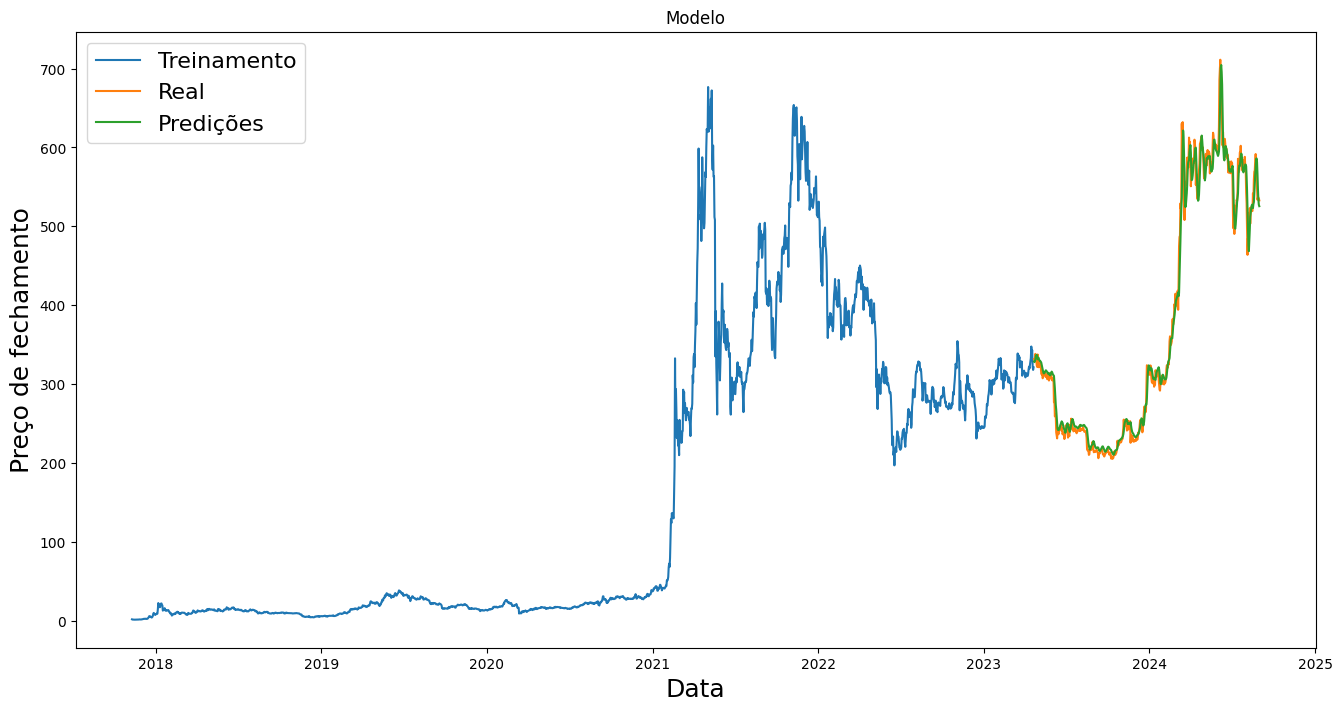

In [44]:
# Setar a data como index dos df (df_previsao e treinamento)
df_previsao.set_index('Date', inplace=True)
treinamento.set_index('Date', inplace=True)

plt.figure(figsize =(16, 8))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 18)
plt.ylabel("Preço de fechamento", fontsize = 18)
plt.plot(treinamento[['Price']])
plt.plot(df_previsao[['Price', 'predicoes']])
plt.legend(['Treinamento', 'Real', 'Predições'], loc=2, prop={'size': 16})
plt.show()

In [45]:
df_previsao.sort_index()

df_previsao

,Price,predicoes
Date,,
2023-04-22,332.08,328.731445
2023-04-23,330.70,327.977386
2023-04-24,331.10,329.246796
2023-04-25,338.39,331.316193
2023-04-26,330.50,335.316223
...,...,...
2024-08-27,533.68,566.328613
2024-08-28,536.60,547.202087
2024-08-29,536.51,533.870667


In [46]:
df_previsao_semanal = df_previsao
df_previsao_semanal['Semana'] = ((df_previsao_semanal.index - df_previsao_semanal.index.min()).days // 7) + 1
df_previsao_semanal.head(30)

,Price,predicoes,Semana
Date,,,
2023-04-22,332.08,328.731445,1
2023-04-23,330.70,327.977386,1
2023-04-24,331.10,329.246796,1
2023-04-25,338.39,331.316193,1
2023-04-26,330.50,335.316223,1
2023-04-27,330.70,336.877716,1
2023-04-28,324.10,337.131714,1
2023-04-29,321.90,334.876373,2
2023-04-30,337.58,331.559814,2


# Metricas para calcular nosso modelo de ML

### Mean Absolute Error (MAE) e Mean Absolute Percentage Error (MAPE)

In [47]:
# A média das diferenças absolutas entre as previsões e os valores reais. Penaliza todos os erros da mesma forma

mae = mean_absolute_error(df_previsao['Price'], df_previsao['predicoes'])

print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Absolute Error (MAE): 10.98


In [48]:
# Calcular o MAPE
mape = mean_absolute_percentage_error(df_previsao['Price'], df_previsao['predicoes'])

print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f} = {100*mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 0.0287 = 2.87%


### Root Mean Squared Error (RMSE)

In [49]:
# A raiz quadrada da média dos erros ao quadrado. Dá mais peso a grandes erros

rmse = mean_squared_error(df_previsao['Price'], df_previsao['predicoes'], squared=False)
mean_price = df_previsao['Price'].mean()

print(f"RMSE: {rmse}")
print(f"RMSE percentual: {(rmse / mean_price)*100:.3}%")

RMSE: 16.279289876957122
RMSE percentual: 4.33%


c:\Users\Arq. Andrea\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### R² (Coeficiente de Determinação)

In [50]:
# o R² mede a proporção da variância nos dados que é explicada pelo modelo. Um valor de 1 significa previsões 
# perfeitas, enquanto valores negativos indicam que o modelo é pior do que uma simples média.

r2 = r2_score(df_previsao['Price'], df_previsao['predicoes'])

print(f"R²: {r2}")
print(f"R²: {r2*100:.4}%")

R²: 0.9888596489850503
R²: 98.89%


### Directional Accuracy (Diário)

In [51]:
# Cálculo da variação percentual entre os valores consecutivos
df_previsao['Variação Real (%)'] = df_previsao['Price'].pct_change() * 100
df_previsao['Variação Prevista (%)'] = df_previsao['predicoes'].pct_change() * 100

# Remover NaN (primeira linha não terá variação por não ter valor anterior)
df_teste_diario = df_previsao.dropna()

# Calcular se a direção do valor previsto foi igual ao real (1 = acertou | 0 = errou)
df_teste_diario['direcao_correta'] = np.where(
    (df_teste_diario['Variação Real (%)'] > 0) & (df_teste_diario['Variação Prevista (%)'] > 0) |
    (df_teste_diario['Variação Real (%)'] < 0) & (df_teste_diario['Variação Prevista (%)'] < 0),
    1, 0
)

# Calcular a métrica de Erro de Direção (Directional Accuracy)
directional_accuracy = df_teste_diario['direcao_correta'].mean()

# Exibir resultados
print(f"Directional Accuracy (Diário): {directional_accuracy * 100:.2f}%")

df_teste_diario

Directional Accuracy (Diário): 50.30%


,Price,predicoes,Semana,Variação Real (%),Variação Prevista (%),direcao_correta
Date,,,,,,
2023-04-23,330.70,327.977386,1,-0.415563,-0.229383,1
2023-04-24,331.10,329.246796,1,0.120956,0.387037,1
2023-04-25,338.39,331.316193,1,2.201752,0.628519,1
2023-04-26,330.50,335.316223,1,-2.331629,1.207316,0
2023-04-27,330.70,336.877716,1,0.060514,0.465679,1
...,...,...,...,...,...,...
2024-08-27,533.68,566.328613,71,-2.666423,-2.591056,1
2024-08-28,536.60,547.202087,71,0.547144,-3.377283,0
2024-08-29,536.51,533.870667,71,-0.016772,-2.436286,1


### Directional Accuracy (Semanal)

In [52]:
# Agrupar por semana e calcular o preço médio semanal para real e previsões
df_teste_semana = df_previsao_semanal.groupby('Semana').agg({
    'Price': 'mean',        # Preço real médio por semana
    'predicoes': 'mean'     # Previsão média por semana
})

# Calcular a variação percentual semanal para Price e Predicoes
df_teste_semana['Variação Real (%)'] = df_teste_semana['Price'].pct_change() * 100
df_teste_semana['Variação Prevista (%)'] = df_teste_semana['predicoes'].pct_change() * 100


# Remover NaN (primeira linha não terá variação por não ter valor anterior)
df_teste_semana = df_teste_semana.dropna()

# Calcular se a direção do valor previsto foi igual ao real (1 = acertou | 0 = errou)
df_teste_semana['direcao_correta'] = np.where(
    (df_teste_semana['Variação Real (%)'] > 0) & (df_teste_semana['Variação Prevista (%)'] > 0) |
    (df_teste_semana['Variação Real (%)'] < 0) & (df_teste_semana['Variação Prevista (%)'] < 0),
    1, 0
)

# Calcular a métrica de Erro de Direção (Directional Accuracy)
directional_accuracy = df_teste_semana['direcao_correta'].mean()

# Exibir resultados
print(f"Directional Accuracy (Semanal): {directional_accuracy * 100:.2f}%")

df_teste_semana

Directional Accuracy (Semanal): 74.65%


,Price,predicoes,Variação Real (%),Variação Prevista (%),direcao_correta
Semana,,,,,
2,326.541429,332.025208,-1.371264,-0.104058,1
3,314.171429,323.560699,-3.788187,-2.549356,1
4,311.441429,315.559418,-0.868952,-2.472883,1
5,308.158571,314.163910,-1.054085,-0.442231,1
6,309.042857,313.554626,0.286958,-0.193936,0
...,...,...,...,...,...
68,496.491429,506.344666,-13.606229,-11.838317,1
69,518.791429,517.930969,4.491518,2.288222,1
70,563.672857,545.317444,8.651151,5.287671,1


In [36]:
#criando um código que você passa 60 dias e ele devolve a cotação
#resumindo: vamos descobrir o preço da petrobras de hoje/amanha com esse modelo

# data_hoje = datetime.now()

#se quiser escolher um dia, basta fazer assim

#data_hoje = datetime.now() - timedelta(days = 1)

# if data_hoje.hour > 18:
    
#     final = data_hoje
#     inicial = datetime.now() - timedelta(days = 252)
    
# else:
#     final = data_hoje - timedelta(days = 1)
#     inicial = datetime.now() - timedelta(days = 252)
    
# ultimos_60_dias = acao['Price'].iloc[-60:].values.reshape(-1, 1)

# ultimos_60_dias_escalado = escalador.transform(ultimos_60_dias)

# teste_x = []
# teste_x.append(ultimos_60_dias_escalado)
# teste_x = np.array(teste_x)
# teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

# previsao_de_preco = modelo.predict(teste_x)
# previsao_de_preco = escalador.inverse_transform(previsao_de_preco)

# print(previsao_de_preco)